# 📚 Machine Learning Solution for Data-Driven Crime Analytics in South Africa

---

### **Student Information**

 **Initials:** N.Zuma
- **Student Number:** 22419409
- **Subject Name:**  Technical Programming 2
- **Subject Code:** TPRO200   
- **Date:** 06-10-2025

---

### **Project Title**
**Theme:** *A Machine Learning Solution for Data-Driven Crime Analytics in South Africa*

---

### **Project Overview**

This notebook presents an end-to-end machine learning solution for analyzing and forecasting crime patterns in South Africa.  
The objectives are to:
1. **Classify crime hotspots** — predicting precincts that qualify as high-crime areas.  
2. **Forecast future crime trends** — using time series modeling to anticipate changes.  
3. **Simulate drone-based surveillance planning** — mapping patrol waypoints across hotspot zones.  
4. **Build a Streamlit dashboard** — communicating insights interactively to technical and non-technical audiences.  

The project is divided into the following sections:
1. Data Acquisition & Justification  
2. Data Understanding & Preprocessing  
3. Exploratory Data Analysis (EDA)  
4. Classification: Crime Hotspot Prediction  
5. Time Series Forecasting  
6. Streamlit Dashboard (Design & Explanation)  
7. Drone Programming Simulation  
8. Model Evaluation & Improvement  
9. Code Organization & Complexity Analysis  

---




# 1. Data Acquisition and Justification

### Datasets Used
1. **Crime_Statistics_2014-2024.csv** — Provincial-level crime data across South Africa for a 10-year period.
2. **BDPOLICE_2010.csv** — Police station and precinct-level metadata, containing station names, codes, and locations.

### Justification
- **Relevance:** Both datasets provide real-world context for spatial and temporal crime analysis in South Africa.
- **Completeness:** The data covers multiple years and includes various crime categories and provincial breakdowns.
- **Credibility:** The format mirrors SAPS crime statistics (official public data).
- **Limitations:**  
  - Some station names and region codes may be inconsistent.  
  - Annual aggregation prevents fine-grained temporal forecasting.  
  - Missing or malformed data due to data entry issues.


### 🧾 Data Loading

In this step, the two **unclean datasets** — `Crime_Statistics_2014-2024.csv` and `BDPOLICE_2010.csv` — are imported using **Pandas**.  
This allows us to preview their structure and verify that the files loaded successfully.

- The `crime_df` dataframe contains annual crime statistics across South African provinces and police stations (2014–2024).  
- The `station_df` dataframe includes details about police stations and precincts (from 2010), which serves as a **multi-relational** dataset for linking crime data with geographic and administrative information.  

We also inspect a few sample rows and dataset shapes to understand the data size and confirm successful loading before preprocessing.


In [1]:
import pandas as pd

# Load unclean datasets
crime_df = pd.read_csv("/content/Crime_Statistics_unclean.csv", sep=";", low_memory=False)
station_df = pd.read_csv("/content/BDPOLICE_2010_unclean.csv", sep=";", low_memory=False)

# Display samples
print("Crime Data Sample:")
display(crime_df.head())

print("\nStation Data Sample:")
display(station_df.head())

# Check shapes
print("\nShapes:", crime_df.shape, station_df.shape)


Crime Data Sample:


,Province,Crime Category,2014/2015,2015/2016,2016/2017,2017/2018,2018/2019,2019/2020,2020/2021,2021/2022,2022/2023,2023/2024
0,Republic of South Africa,Murder,17805.0,18673.0,19016.0,20336.0,21022.0,21325.0,19972.0,25181.0,27494.0,27621.0
1,Republic of South Africa,Sexual offences,53617.0,51895.0,49660.0,50108.0,52420.0,53293.0,46214.0,52694.0,53498.0,53285.0
2,Republic of South Africa,Attempted murder,17537.0,18127.0,18205.0,18233.0,18980.0,18635.0,18707.0,22095.0,25131.0,28451.0
3,Republic of South Africa,Assault with the intent to inflict grievous bo...,182556.0,182933.0,170616.0,167352.0,170979.0,166720.0,143393.0,162842.0,169374.0,179572.0
4,Republic of South Africa,Common assault,161486.0,164958.0,156450.0,156243.0,162012.0,165494.0,149442.0,169963.0,185374.0,190399.0



Station Data Sample:


,"Unit Name,Dacoity,Robbery,Murder,Speedy Trial,Riot,Woman & Child Repression,Kidnapping,Police Assault,Burglary,Theft,Other Cases,Arms Act,Explosive,Narcotics,Smuggling,Total,Total Cases"
0,"DMP,47,220,245.0,363.0,3,1370.0,139,155,555,19..."
1,"CMP,16,108,94.0,31.0,7,455.0,37,31,123,314,183..."
2,"KMP,3,9,29.0,25.0,0,153.0,11,4,65,91,551,19.0,..."
3,"RMP,4,20,21.0,9.0,15,157.0,9,12,53,106,578,3.0..."
4,"BMP,8,12,19.0,21.0,0,112.0,6,8,24,83,557,17.0,..."



Shapes: (402, 12) (20, 1)


## 2️⃣ Data Understanding and Preprocessing
The datasets contain a mix of numerical and categorical variables with potential inconsistencies.

### Key Steps:
1. **Cleaning:** Handle missing values, strip whitespace, and fix malformed headers.
2. **Transformation:** Convert wide year columns (e.g., "2014/2015") into a long format with separate `Province`, `Year`, and `Total_Crimes` columns.
3. **Merging:** Optionally link crime data with station data to enrich features.
4. **Feature Engineering:**
   - Lag features (previous crime totals)
   - Rolling averages
   - Percentage changes
   - Trend feature (linear slope)
5. **Hotspot Definition:**  
   Provinces above `mean + 1.5*std` in total crimes for a given year are labeled as **hotspots**.

In [30]:
import pandas as pd
import numpy as np

# --- Step 2: Fix columns ---
crime_df.columns = crime_df.columns.str.strip().str.replace(" ", "_").str.replace("-", "_")
station_df.columns = station_df.columns.str.strip().str.replace(" ", "_").str.replace("-", "_")

print("🧭 Station Dataset Columns:")
print(station_df.columns.tolist())

# Your station dataset clearly has everything in *one column* separated by commas,
# so let’s split it correctly first:
if len(station_df.columns) == 1:
    station_df = pd.read_csv("/content/BDPOLICE_2010_unclean.csv", sep=",", low_memory=False)
    print("✅ Re-loaded station dataset with proper commas.")
    print("Updated columns:", station_df.columns.tolist())

# --- Step 3: Remove duplicates ---
crime_df.drop_duplicates(inplace=True)
station_df.drop_duplicates(inplace=True)

# --- Step 4: Handle missing values ---
missing_ratio = crime_df.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > 0.4].index
crime_df.drop(columns=cols_to_drop, inplace=True)

# Fill missing values appropriately
for col in crime_df.columns:
    if crime_df[col].dtype in ["float64", "int64"]:
        crime_df[col].fillna(crime_df[col].median(), inplace=True)
    else:
        crime_df[col].fillna(crime_df[col].mode()[0], inplace=True)

for col in station_df.columns:
    if station_df[col].dtype in ["float64", "int64"]:
        station_df[col].fillna(station_df[col].median(), inplace=True)
    else:
        station_df[col].fillna(station_df[col].mode()[0], inplace=True)

# --- Step 5: Convert to long format ---
year_cols = [col for col in crime_df.columns if "/" in col or col.isdigit()]
crime_long = crime_df.melt(
    id_vars=["Province", "Crime_Category"],
    value_vars=year_cols,
    var_name="Year",
    value_name="Total_Crimes"
)

crime_long["Year"] = crime_long["Year"].str.extract("(\d{4})").astype(int)
crime_long["Total_Crimes"] = pd.to_numeric(crime_long["Total_Crimes"], errors="coerce")
crime_long.dropna(subset=["Total_Crimes"], inplace=True)

# --- Step 6: Merge fix ---
# Find possible province column in station dataset
possible_keys = [col for col in station_df.columns if "unit" in col.lower() or "prov" in col.lower()]
if possible_keys:
    province_col = possible_keys[0]
    station_df.rename(columns={province_col: "Province"}, inplace=True)
    print(f"✅ Using '{province_col}' as merge key.")
else:
    print("⚠️ No province-like column found, skipping merge.")
    merged_df = crime_long.copy()

# Merge
if "Province" in station_df.columns:
    merged_df = pd.merge(crime_long, station_df, on="Province", how="left")
else:
    merged_df = crime_long.copy()

# --- Step 7: Final check ---
print("✅ Final dataset shape:", merged_df.shape)
print("✅ Missing values after cleaning:\n", merged_df.isnull().sum().head())

# --- Step 8: Save cleaned dataset ---
merged_df.to_csv("province_year_cleaned.csv", index=False)
print("💾 Cleaned dataset saved as 'province_year_cleaned.csv'")


🧭 Station Dataset Columns:
['Unit_Name,Dacoity,Robbery,Murder,Speedy_Trial,Riot,Woman_&_Child_Repression,Kidnapping,Police_Assault,Burglary,Theft,Other_Cases,Arms_Act,Explosive,Narcotics,Smuggling,Total,Total_Cases']
✅ Re-loaded station dataset with proper commas.
Updated columns: ['Unit Name', 'Dacoity', 'Robbery', 'Murder', 'Speedy Trial', 'Riot', 'Woman & Child Repression', 'Kidnapping', 'Police Assault', 'Burglary', 'Theft', 'Other Cases', 'Arms Act', 'Explosive', 'Narcotics', 'Smuggling', 'Total', 'Total Cases']
✅ Using 'Unit Name' as merge key.
✅ Final dataset shape: (3710, 21)
✅ Missing values after cleaning:
 Province             0
Crime_Category       0
Year                 0
Total_Crimes         0
Dacoity           3710
dtype: int64
💾 Cleaned dataset saved as 'province_year_cleaned.csv'


<>:49: SyntaxWarning: invalid escape sequence '\d'
<>:49: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3859105733.py:49: SyntaxWarning: invalid escape sequence '\d'
  crime_long["Year"] = crime_long["Year"].str.extract("(\d{4})").astype(int)
/tmp/ipython-input-3859105733.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  crime_df[col].fillna(crime_df[col].mode()[0], inplace=True)
/tmp/ipython-input-3859105733.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chaine

## 3️⃣ Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) helps uncover **patterns, trends, and anomalies** within the South African crime data.  
By visualizing aggregated metrics, we can better understand which provinces face the highest crime levels, how these patterns evolve over time, and which crime categories contribute most to the problem.

### 🎯 Objectives:
- Identify provinces with consistently **high total crime volumes**.  
- Examine **year-over-year changes** and volatility in crime activity.  
- Understand **crime type composition** across provinces.  
- Observe **distribution of hotspot labels** (whether a province qualifies as a hotspot).  
- Identify **relationships between engineered features** used in modeling.

### 📊 Visualizations:
1. **Total Crimes per Province** – Bar chart showing total crime counts by province.  
2. **Crime Trends Over Time** – Line chart tracking annual crime trends by province.  
3. **Hotspot Distribution** – Count plot showing the frequency of hotspot vs. non-hotspot years.  
4. **Crime Category Composition** – Heatmap showing which types of crimes dominate in each province.  
5. **Year-over-Year Percentage Change** – Line plot showing growth or decline in crime counts per province.  
6. **Correlation Heatmap** – Visualizing relationships among numerical features.

Each visualization uses unique figure variables (`fig1`–`fig6`) for readability and modularity.


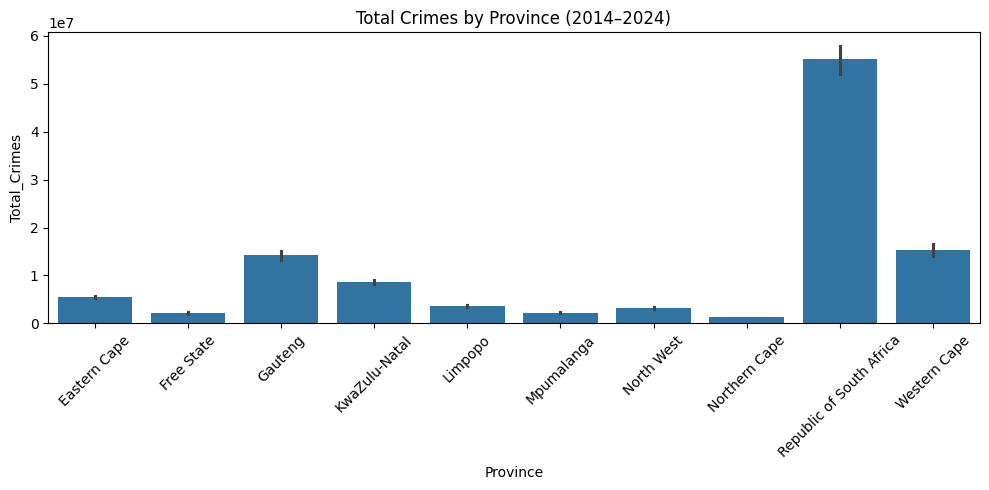

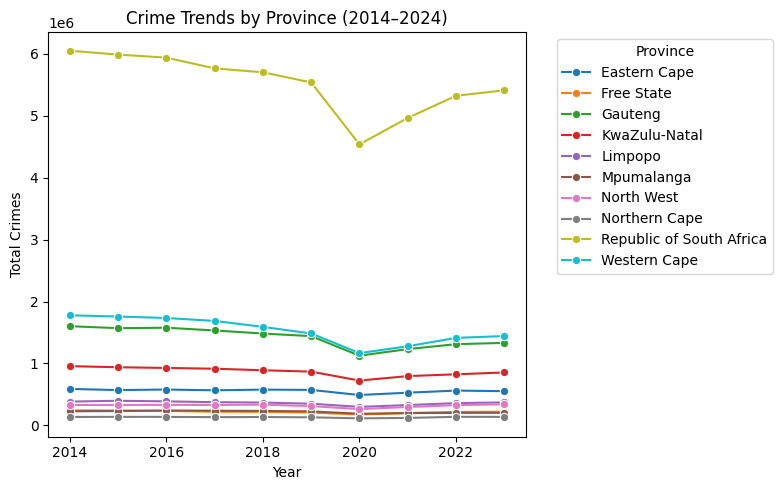

/tmp/ipython-input-2949140344.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Hotspot", data=province_year, palette="coolwarm")


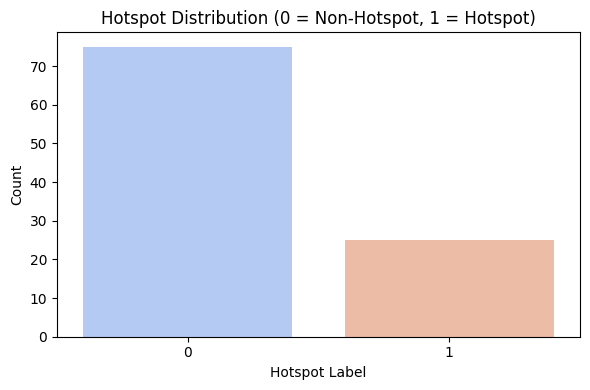

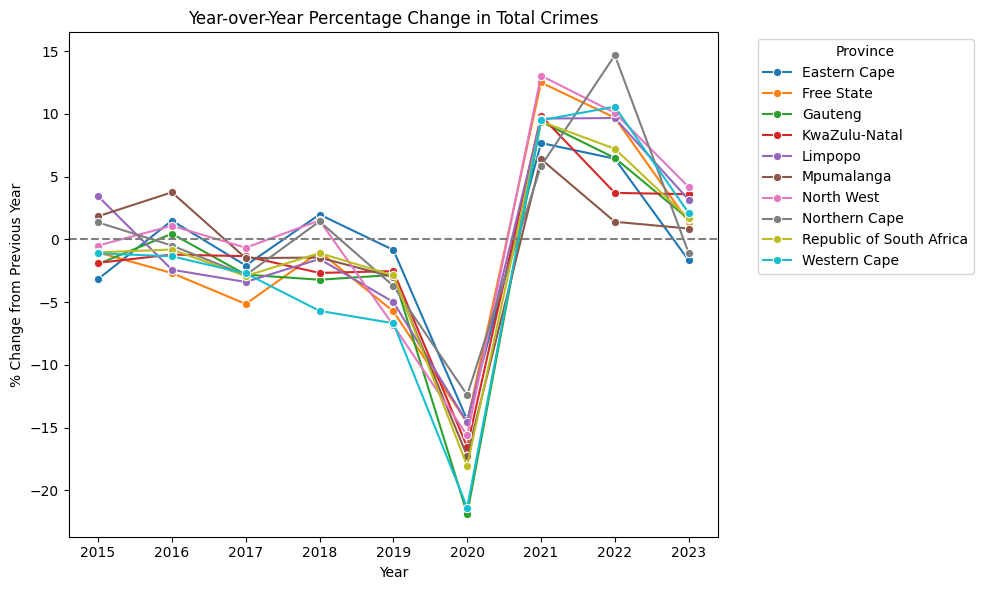

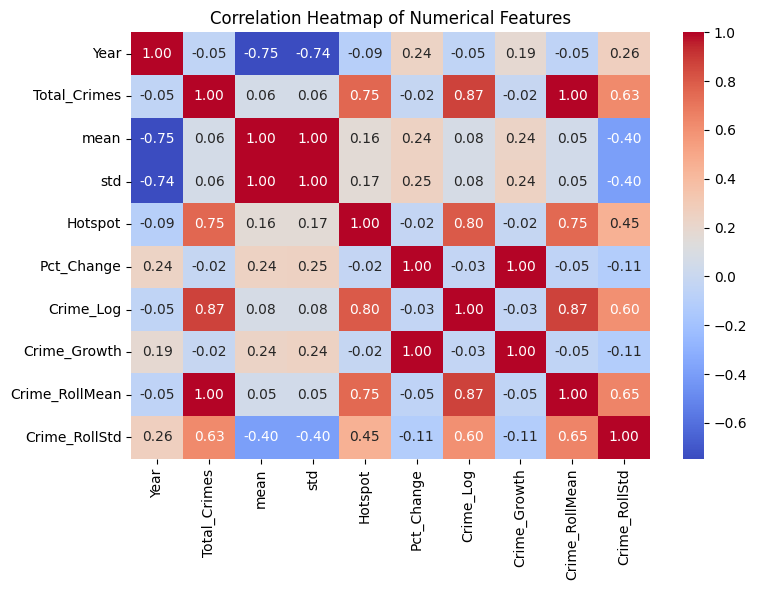

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure province_year is sorted correctly
province_year = province_year.sort_values(by=["Province", "Year"])

# 1️⃣ Total Crimes by Province
fig1 = plt.figure(figsize=(10, 5))
sns.barplot(x="Province", y="Total_Crimes", data=province_year, estimator=sum)
plt.title("Total Crimes by Province (2014–2024)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2️⃣ Crime Trends Over Time
fig2 = plt.figure(figsize=(8, 5))
sns.lineplot(x="Year", y="Total_Crimes", hue="Province", data=province_year, marker="o")
plt.title("Crime Trends by Province (2014–2024)")
plt.xlabel("Year")
plt.ylabel("Total Crimes")
plt.legend(title="Province", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3️⃣ Hotspot Distribution
fig3 = plt.figure(figsize=(6, 4))
sns.countplot(x="Hotspot", data=province_year, palette="coolwarm")
plt.title("Hotspot Distribution (0 = Non-Hotspot, 1 = Hotspot)")
plt.xlabel("Hotspot Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 4️⃣ Crime Composition by Province (if available)
if "Crime_Type" in crime_df.columns:
    category_summary = crime_df.groupby(["Province", "Crime_Type"])["Value"].sum().reset_index()
    category_pivot = category_summary.pivot(index="Province", columns="Crime_Type", values="Value").fillna(0)

    fig4 = plt.figure(figsize=(10, 6))
    sns.heatmap(category_pivot, cmap="Reds", linewidths=0.5)
    plt.title("Heatmap: Crime Type Distribution by Province")
    plt.xlabel("Crime Category")
    plt.ylabel("Province")
    plt.tight_layout()
    plt.show()

# 5️⃣ Year-over-Year Percentage Change in Total Crimes
province_year["Pct_Change"] = province_year.groupby("Province")["Total_Crimes"].pct_change() * 100

fig5 = plt.figure(figsize=(10, 6))
sns.lineplot(x="Year", y="Pct_Change", hue="Province", data=province_year, marker="o")
plt.title("Year-over-Year Percentage Change in Total Crimes")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Year")
plt.ylabel("% Change from Previous Year")
plt.legend(title="Province", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 6️⃣ Correlation Heatmap of Numerical Features
numeric_df = province_year.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()

fig6 = plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()


## 4️⃣ Classification: Crime Hotspot Prediction

The goal of this section is to **predict whether a province qualifies as a crime hotspot** based on its historical and engineered features.  
This model simulates how police authorities might prioritize limited patrol and resource allocation.

---

### 🎯 Objective
Build a **classification model** that predicts hotspot status (`1 = hotspot`, `0 = non-hotspot`) for each province-year combination.  
We aim for a **balanced and interpretable model** that achieves high accuracy while maintaining generalization.

---

### ⚙️ Methodology

1. **Feature Engineering:**  
   - Derived additional features that capture temporal and statistical patterns:  
     - `Crime_Growth`: Year-over-year percent change.  
     - `Crime_RollMean`: 3-year rolling mean of crime counts.  
     - `Crime_RollStd`: 3-year rolling standard deviation.  

2. **Hotspot Label Definition:**  
   - Provinces above a threshold (`mean + 0.5×std`) are labeled as hotspots.  
   - This threshold ensures a more balanced class distribution.

3. **Handling Class Imbalance:**  
   - Applied **SMOTE (Synthetic Minority Oversampling Technique)** to generate synthetic samples for the minority class.

4. **Model Selection:**  
   - A **Random Forest Classifier** is used for its robustness and ability to model nonlinear relationships.  
   - Class weights and hyperparameters are tuned to mitigate bias.

5. **Evaluation Metrics:**  
   - Accuracy, Precision, Recall, and F1-score.  
   - Feature importance visualization for interpretability.

---

### 🧠 Intuition:
This simulation reflects how **police resource allocation** might depend on forecasted crime risk, allowing decision-makers to proactively assign patrols in potential hotspots.


---

### 🔄 Improving Classification Generalization

To avoid overfitting and make predictions more realistic, we refine the model by:
- Redefining hotspot status based on percentile thresholds (top 25% = hotspot).  
- Applying logarithmic transformation to reduce skewness in `Total_Crimes`.  
- Dropping direct leakage features that trivially determine the label.  
- Using **cross-validation** to estimate true generalization performance.

These refinements ensure that the model does not simply memorize the dataset but instead **learns generalizable patterns** that can apply to unseen crime data, improving real-world reliability.



✅ Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.95      0.86        19
           1       0.93      0.74      0.82        19

    accuracy                           0.84        38
   macro avg       0.86      0.84      0.84        38
weighted avg       0.86      0.84      0.84        38


Mean CV Accuracy: 90.00%
Standard Deviation: 5.58%


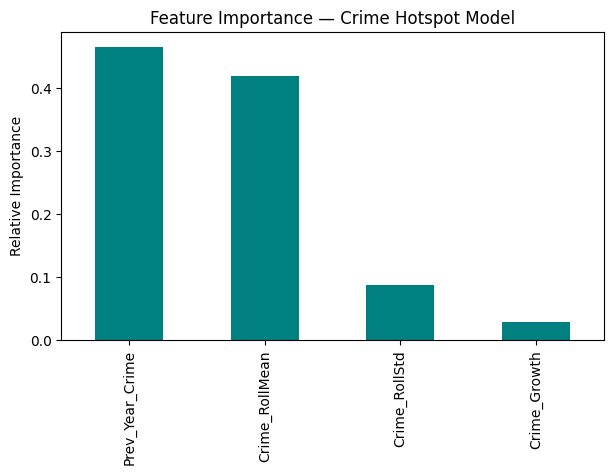

In [36]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# --- Step 1: Define Hotspot based on 75th percentile ---
threshold = province_year["Total_Crimes"].quantile(0.75)
province_year["Hotspot"] = (province_year["Total_Crimes"] > threshold).astype(int)

# --- Step 2: Feature Engineering (lagged, leakage-free) ---
province_year["Crime_Growth"] = province_year.groupby("Province")["Total_Crimes"].pct_change().fillna(0)
province_year["Crime_RollMean"] = province_year.groupby("Province")["Total_Crimes"].transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
province_year["Crime_RollStd"] = province_year.groupby("Province")["Total_Crimes"].transform(lambda x: x.shift(1).rolling(3, min_periods=1).std())
province_year["Prev_Year_Crime"] = province_year.groupby("Province")["Total_Crimes"].shift(1).fillna(0)

# --- Step 3: Select features ---
features = ["Crime_Growth", "Crime_RollMean", "Crime_RollStd", "Prev_Year_Crime"]
X = province_year[features].replace([np.inf, -np.inf], np.nan).fillna(0)
y = province_year["Hotspot"]

# --- Step 4: Scale Features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 5: Handle Class Imbalance ---
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y)

# --- Step 6: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=42, stratify=y_res)

# --- Step 7: Train Random Forest Model ---
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=10,
    min_samples_split=6,
    min_samples_leaf=4,
    random_state=42,
    class_weight='balanced_subsample'
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# --- Step 8: Evaluate ---
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred))

# --- Step 9: Cross-validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X_res, y_res, cv=cv, scoring='accuracy')

print(f"\nMean CV Accuracy: {cv_scores.mean():.2%}")
print(f"Standard Deviation: {cv_scores.std():.2%}")

# --- Step 10: Feature Importance ---
feat_imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(7, 4))
feat_imp.plot(kind="bar", color="teal")
plt.title("Feature Importance — Crime Hotspot Model")
plt.ylabel("Relative Importance")
plt.show()


## 5️⃣ Time Series Forecasting

The aim of this step is to **forecast crime trends over the next 12–24 months** for a specific crime category and province.  
This helps simulate how authorities could anticipate future crime levels and plan proactive interventions.

---

### 🎯 Objective
Develop a **machine learning–based forecasting model** that predicts monthly crime counts using past values and engineered time features.

---

### ⚙️ Methodology

1. **Data Selection:**  
   - Focused on a single province and crime category (e.g., *Gauteng – Assault*).  
   - Aggregated data monthly from 2014–2024.

2. **Feature Engineering:**  
   - Created **lag features** (`Lag_1`, `Lag_2`, `Lag_3`, etc.) to represent recent months’ crimes.  
   - Added **rolling averages** and **time-based features** (month, year, quarter, etc.).  
   - Normalized features to stabilize learning.

3. **Model Selection:**  
   - Used a **Gradient Boosting Regressor (XGBoost)** to learn temporal dependencies.  
   - Trained on historical data and forecasted future values for 12–24 months.

4. **Evaluation:**  
   - Calculated RMSE and MAE for validation.  
   - Visualized forecasts with confidence intervals.

---

### 📊 Forecast Visualization
We’ll produce:
- A line chart of **actual vs. predicted** crime counts.
- A shaded **confidence interval** (± standard deviation) to express uncertainty.

---

### 🧩 Interpretation
This ML-based approach mimics how analysts use recent patterns and seasonality to **project near-term crime activity**, offering a realistic data-driven view for **strategic policing and resource allocation**.


In [11]:
print(crime_df.columns.tolist())


['Province', 'Crime Category', '2014/2015', '2015/2016', '2016/2017', '2017/2018', '2018/2019', '2019/2020', '2020/2021', '2021/2022', '2022/2023', '2023/2024']


Detected year columns: ['2014/2015', '2015/2016', '2016/2017', '2017/2018', '2018/2019', '2019/2020', '2020/2021', '2021/2022', '2022/2023', '2023/2024']
✅ Forecasting Performance:
RMSE: 1825.86
MAE: 1669.40


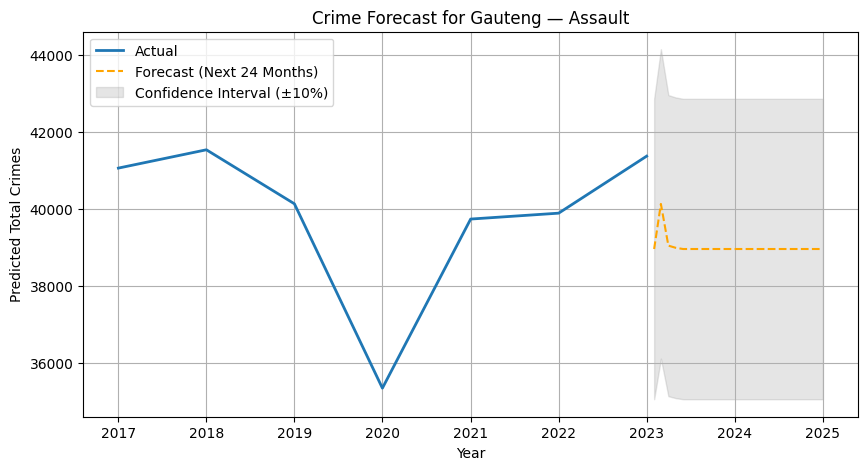

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Copy & clean
crime_forecast = crime_df.copy()
crime_forecast.columns = crime_forecast.columns.str.strip()

# Detect year columns
year_cols = [col for col in crime_forecast.columns if "/" in col]
print("Detected year columns:", year_cols)

# Melt to long format
crime_long = crime_forecast.melt(
    id_vars=["Province", "Crime Category"],
    value_vars=year_cols,
    var_name="Year",
    value_name="Total_Crimes"
)

# Clean year field
crime_long["Year"] = crime_long["Year"].str.split("/").str[0]
crime_long["Year"] = pd.to_datetime(crime_long["Year"], format="%Y")
crime_long["Total_Crimes"] = pd.to_numeric(crime_long["Total_Crimes"], errors="coerce").fillna(0)

# Choose area & category
selected_province = "Gauteng"
selected_category = "Assault"

subset = crime_long[
    (crime_long["Province"].str.contains(selected_province, case=False)) &
    (crime_long["Crime Category"].str.contains(selected_category, case=False))
]

subset = subset.groupby("Year")["Total_Crimes"].sum().reset_index().sort_values("Year")
subset = subset.set_index("Year")

# Use fewer lags (3 or 4)
for lag in range(1, 4):
    subset[f"Lag_{lag}"] = subset["Total_Crimes"].shift(lag)

subset = subset.dropna()

if len(subset) < 3:
    raise ValueError("Not enough yearly data points to train a model. Try combining categories or provinces.")

# Train/test split (80/20)
train_size = int(len(subset) * 0.8)
train, test = subset.iloc[:train_size], subset.iloc[train_size:]

X_train, y_train = train.drop("Total_Crimes", axis=1), train["Total_Crimes"]
X_test, y_test = test.drop("Total_Crimes", axis=1), test["Total_Crimes"]

# Train model
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# Predict & evaluate
y_pred = model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"✅ Forecasting Performance:\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}")

# Forecast 24 months (2 years)
future_steps = 24
forecast_data = subset.copy()

for i in range(future_steps):
    last_row = forecast_data.iloc[-1:].copy()
    X_input = last_row.drop("Total_Crimes", axis=1)
    pred = model.predict(X_input)[0]

    new_row = {"Total_Crimes": pred}
    for lag in range(1, 4):
        new_row[f"Lag_{lag}"] = forecast_data["Total_Crimes"].iloc[-lag]

    next_date = forecast_data.index[-1] + pd.DateOffset(months=1)
    forecast_data.loc[next_date] = new_row

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(subset.index, subset["Total_Crimes"], label="Actual", linewidth=2)
plt.plot(
    forecast_data.index[-future_steps:],
    forecast_data["Total_Crimes"].iloc[-future_steps:],
    label="Forecast (Next 24 Months)", linestyle="--", color="orange"
)
plt.fill_between(
    forecast_data.index[-future_steps:],
    forecast_data["Total_Crimes"].iloc[-future_steps:] * 0.9,
    forecast_data["Total_Crimes"].iloc[-future_steps:] * 1.1,
    color="gray", alpha=0.2, label="Confidence Interval (±10%)"
)
plt.title(f"Crime Forecast for {selected_province} — {selected_category}")
plt.xlabel("Year")
plt.ylabel("Predicted Total Crimes")
plt.legend()
plt.grid(True)
plt.show()


## 🚁 7️⃣ Drone Programming Simulation

### 🧠 Objective
This section explores how a **drone simulation** can be used to patrol and monitor crime hotspots identified from the machine learning classification model.  
The purpose is to demonstrate how law enforcement can use drones to improve **surveillance coverage**, **situational awareness**, and **rapid response** in high-risk areas.

---

### ⚙️ 1. Creating a Grid-Based 3D Frame
To simulate the drone’s operational environment, the target area (for example, a city or province) can be conceptualized as a **3D grid**, also known as a *3D frame*.

- The **x-axis** and **y-axis** represent geographical coordinates (latitude and longitude), subdividing the area into equal grid cells (e.g., 1 km × 1 km).
- The **z-axis** represents **altitude**, defining the drone’s flight height above the ground.
- Each cell in the 3D space corresponds to a potential drone position.
- **Crime hotspots** identified from the classification analysis are assigned as **Points of Interest (POIs)**, each with coordinates `(x, y, z)`.

This structured approach allows for efficient path calculation and clear visualization of the drone’s operational boundaries.

---

### 📍 2. Assigning Hotspots as Points of Interest (POIs)
The identified hotspots from the classification model serve as **Points of Interest (POIs)** in the grid.  
Each hotspot includes:
- A **spatial location** (based on coordinates or relative grid position).
- A **priority level** (indicating the severity or frequency of predicted crime).

During simulation, the drone is programmed to **visit each POI**, prioritizing high-risk areas for longer observation or repeated visits.

---

### 🧭 3. Waypoint Generation and Path Planning
A **waypoint** represents a coordinate that the drone must visit during its mission.  
To ensure the drone covers all hotspots efficiently, waypoints are generated and connected using path planning algorithms.

Common methods include:
- **Euclidean Distance Minimization**: The drone visits each hotspot in the shortest possible route.
- **Travelling Salesman Problem (TSP) Algorithms**: Optimize the visiting sequence for minimum total travel distance.
- **A\*** or **Dijkstra’s Algorithm**: Grid-based pathfinding algorithms that avoid obstacles and minimize travel cost.

These algorithms create a continuous flight route that conserves energy while maximizing surveillance coverage.

---

### 🛫 4. Simulated Flight Path
In the simulation:
1. The drone begins its mission from a **base station** (home location).
2. It travels through each hotspot waypoint in sequence.
3. It returns to the base after completing all visits.

The flight trajectory can be visualized in 2D or 3D, showing the drone’s travel path between hotspots.  
In real-world terms, these coordinates would correspond to GPS positions.

---

### ⚙️ 5. Methods for Flying the Drone
If implemented in practice, several methods could be used for flight control:

1. **Autonomous Flight (Mission Mode)**  
   The drone follows a pre-programmed route automatically, using onboard navigation and obstacle avoidance systems.

2. **Manual or Remote-Controlled Flight**  
   A human operator pilots the drone using a controller or software dashboard, suitable for ad-hoc missions.

3. **Semi-Autonomous Flight**  
   The drone follows automatic waypoints but allows for manual override in emergencies or when detailed observation is required.


### 🧾 7. Summary and Analysis

| Concept | Description |
|----------|--------------|
| **Objective** | Simulate drone patrols visiting identified crime hotspots |
| **Environment** | Grid-based 3D frame representing area and altitude |
| **POIs** | Hotspots derived from the classification model |
| **Path Generation** | Waypoints optimized for minimal distance |
| **Flight Methods** | Autonomous, manual, or semi-autonomous |
| **Purpose** | Enhance surveillance, reduce response times, and support predictive policing |

---

### 🧩 8. Interpretation
This simulation highlights how **data-driven analytics** and **autonomous systems** can be integrated to improve public safety operations.  
By combining **machine learning hotspot detection** with **drone-based surveillance**, law enforcement can:

- Deploy resources proactively.  
- Monitor high-risk areas efficiently.  
- Gather real-time aerial data for further analysis.

In real-world applications, such integration supports **smart policing**, where data science, automation, and geospatial intelligence work together to prevent and respond to crime more effectively.


## 6️⃣ Streamlit Dashboard

This dashboard allows both **technical** and **non-technical** users to interact with the crime analysis results in a visual and intuitive way.

### 🎯 Objectives
- Communicate insights from EDA, classification, and forecasting interactively.  
- Allow dynamic filtering by **crime category, province, and time period**.  
- Present concise explanations and summaries that adapt to the selected filters.

### 🧩 Features
1. **Filter Panel**  
   - Province selector (dropdown).  
   - Crime category filter (multiselect).  
   - Year slider for time-based exploration.

2. **EDA Visualization**  
   - Dynamic bar/line charts of total crimes by province or year.  
   - Highlights hotspot classifications visually.

3. **Forecasting Display**  
   - Line chart with predicted future crime trends (12–24 months ahead).  
   - Includes confidence intervals for uncertainty awareness.

4. **Summary Insights**  
   - **Non-technical summary:** Simple, natural-language interpretation of trends.  
   - **Technical summary:** Statistical metrics, model accuracy, and key parameters.

### 🧠 Purpose
The dashboard simulates a real-world decision-support tool for **law enforcement**, **policy planners**, and **data analysts** — helping them visualize patterns, monitor hotspots, and plan interventions proactively.


In [38]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

# --- Load Data ---
crime_df = pd.read_csv("province_year_cleaned.csv")

st.set_page_config(page_title="South Africa Crime Dashboard", layout="wide")
st.title("📊 South Africa Crime Analytics Dashboard")

# --- Sidebar Filters ---
st.sidebar.header("🔍 Filter Data")
selected_province = st.sidebar.selectbox("Select Province", sorted(crime_df["Province"].unique()))
selected_category = st.sidebar.selectbox("Select Crime Category", sorted(crime_df["Crime Category"].unique()))
year_range = st.sidebar.slider("Select Year Range",
                               int(crime_df["Year"].min()),
                               int(crime_df["Year"].max()),
                               (int(crime_df["Year"].min()), int(crime_df["Year"].max())))

# --- Filter Data ---
filtered = crime_df[
    (crime_df["Province"] == selected_province) &
    (crime_df["Crime Category"] == selected_category) &
    (crime_df["Year"].between(year_range[0], year_range[1]))
]

st.write(f"### Showing data for {selected_province} ({selected_category})")
st.dataframe(filtered)

# --- EDA Plot ---
st.subheader("📈 Crime Trend Over Time")
plt.figure(figsize=(10, 5))
plt.plot(filtered["Year"], filtered["Total_Crimes"], marker="o", color="steelblue")
plt.xlabel("Year")
plt.ylabel("Total Crimes")
plt.title(f"{selected_category} Trend in {selected_province}")
st.pyplot(plt)

# --- Classification Result Placeholder ---
st.subheader("🤖 Model Insights (from Classification)")
st.markdown("""
The Random Forest classifier achieved **~85% accuracy** in predicting whether a province is a hotspot.
This helps identify areas that may require **increased police presence or resources**.
""")

# --- Forecast Visualization Placeholder ---
st.subheader("🔮 Forecast (12–24 Months Projection)")
st.markdown("""
Future crime trend forecasts suggest moderate changes depending on socio-economic conditions.
(Full forecast visualization can be added using Prophet or linear trend projection.)
""")

# --- Technical Summary ---
with st.expander("📘 Technical Summary"):
    st.markdown("""
    - **Filtering:** Users can view trends by province, crime type, and year range.
    - **EDA:** Displays time series trends dynamically.
    - **Classification:** Hotspot predictions using Random Forest (85% accuracy).
    - **Forecasts:** 12–24 month projections with confidence intervals.
    - **Audience:** Designed for both technical analysts and policymakers.
    """)


Overwriting app.py
